# Credit Card Fraud Detection 101

This notebook provides a quick overview on the implementation of a credit card fraud detection system. It is a short version of the
[Machine Learning for Credit Card Fraud Detection - Practical Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html),
which is available at the [Fraud-Detection-Handbook/fraud-detection-handbook](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook)
repository.

For an in depth review of the fraud detection problem, and how to apply Machine Learning techniques to solve it, refer to the links above.
In this short example, we focused on providing a quick overview of the main concepts, and how to apply two different machine learning techniques
to the problem: Logistic Regression and Convolutional Neural Network.

## Dataset Considerations

One of the big problems in creating a credit card fraud detection system is getting access to a real dataset with both legitimate and fraudulent
credit card transactions. For our project we used the dataset simulator provided by the handbook to generate synthetic data for the problem.

The dataset generation step consist on the following steps:

1. Generate customers
1. Generate terminals
1. Associate terminals to customers based on geographic location
1. Generate transactions

Transactions are generated for a set of 5000 customers, 10000 terminals, over a 183 days period of time, totalling in 1.7 million transactions, approximately.

Then, some transactions are modified to simulate different credit card fraud scenarios. Frauds are marked  with a flag. There are with 3 kinds of
credit card fraud scenarios injected in the synthetic data:

**Scenario 1:** Any transaction whose amount is more than $220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide
an obvious fraud pattern that should be detected by any baseline fraud detector.

**Scenario 2:** Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent.
This scenario simulates a criminal use of a terminal, through phishing for example.

**Scenario 3:** Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and
marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make
transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains.

Finally, the raw dataset is saved on disk for further usage by other steps in the project.

## Feature Transformation

As with most datasets, we need to apply some level of feature engineering to make it suitable for our Machine Learning training purposes.

The following transformations are applied to the raw dataset generated in the step before:

1. Mark transactions done in a weekend versus a weekday
1. Mark transactions done at night versus the ones done during the day
1. Identify the number of transactions done by a given customer in different time windows (last 1, 7, 30 days)
1. Identify the spending amount done by a given customer in different time windows (last 1, 7, 30 days)
1. Identify the number of transactions done in a terminal in different time windows (last 1, 7, 30 days)
1. Identify the average number of fraudulent transactions in a given terminal in different time windows (last 1, 7, 30 days)

Every record in the raw dataset is expanded with the information above.

Finally, the transformed dataset is saved on disk for further usage by other steps in the project.

## Performance Metrics Description

In this section we introduce the metrics we use to evaluate the two models trained below.

### AUC ROC

Short for "Area Under the Receiver Operating Characteristic Curve". The ROC part of it is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate (TPR) and False Positive Rate (FPR). An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The AUC part stands for "Area under the ROC Curve." That is, AUC measures the two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

### Average Precision:

Average Precision is a way to summarize the Precision-Recall (PR) curve into a single value. To define the term, the Average Precision metric (or just AP) is the weighted mean of Precision scores achieved at each PR curve threshold, with the increase in Recall from the previous threshold used as the weight.

It is easy to understand the AP value itself. If you are getting more correct predictions, it leads to a better PR curve and, as a result, to higher Average Precision. The higher the metric value, the better. The best possible score is 1, and the worst is 0.

This metric is considered better to evaluate fraud detection problems than the AUC ROC metric.

### Card Precision @100:

Multiple fraudulent transactions from the same card should count as a single correct detection since investigators check all the recent transactions when contacting cardholders. The resulting metric is the Card Precision Top-k, or CP@k, and quantifies the number of correctly detected compromised cards out of the cards which have the highest risks of frauds.

Different from the two previous metrics, which are standard in the Machine Learning practice, this metric is a customization for our fraud detection problem.

### How the metrics are used for training

Now, we could compute several other metrics for our problem, but these three metrics serve the purpose of doing model selection. Model selection consists of  selecting the prediction model that is expected to provide the best performance on future data. The process of doing model selection is:

1. Define a collection of candidate models to be tested with different hyperparameter options.
1. Train each candidate model using the training data. The training  identifies the hyperparameter that maximizes the performance of the model on the training set.
1. Assess the performance of each candidate model by means of a validation procedure
1. Select the model that has the highest validation performance

So, these metrics are used to automatically find the best hyperparameter that gives the best performance.  From there we can compare the best versions of the models / hyperparameters until finally selecting our model.

This is implemented using `sklearn.model_selection.GridSearchCV` method. In a nutshell, for every model we define a set of hyperparameters and a scoring method based on the metrics above.  Then we let `sklearn` tell us which is the best model for the task.

## Logistic Regression Training

The Logistic Regression model is trained using the sklearn.linear_model.LogisticRegression classifier. The main hyperparameters for this model are solver, penalty, and regularization strength. Solver is the algorithm to use in the optimization problem (we use the default lbfgs option), Penalty uses the default selection as L2, and we search for the best model using different Regularization Strength (0.1, 1, 10, 100).

```
parameters = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__random_state": [0]
}
```

## Convolutional Neural Network Training

The Convolutional Neural Network is trained using PyTorch's `torch.nn.Conv1d`, `torch.nn.ConstantPad1d` classes, wrapped with `skorch.NeuralNetClassifier`, so it is compatible with our model selection and evaluation methods done for the other classifiers. Convolutional Neural Networks are significantly more complex than the previous Logistic Regression model  and consequently they have several hyperparameters to tune:

```
parameters = {
    "clf__lr": [0.001],
    "clf__batch_size": [64, 128],
    "clf__max_epochs": [20],
    "clf__module__hidden_size": [500],
    "clf__module__num_conv": [2],
    "clf__module__p": [0.2],
    "clf__module__num_features": [int(len(input_features))],
    "clf__module__num_filters": [200],
}
```

## Fraud Detection Implementation

In the sections below, we present a sample implementation of the credit card fraud detection classifier. The code for this sample is available at the GitHub repository [dnoliver/fraud-detection-sample](https://github.com/dnoliver/fraud-detection-sample).

### Google Collab Dependencies

In the case you are using Google Collab to run this notebook, run the next cell to get the notebook dependencies:

In [ ]:
!curl -O https://raw.githubusercontent.com/dnoliver/fraud-detection-sample/master/utils.py
!curl -O https://raw.githubusercontent.com/dnoliver/fraud-detection-sample/master/dataset_generation.py
!curl -O https://raw.githubusercontent.com/dnoliver/fraud-detection-sample/master/feature_transformation.py
!curl -O https://raw.githubusercontent.com/dnoliver/fraud-detection-sample/master/logistic_regression.py
!curl -O https://raw.githubusercontent.com/dnoliver/fraud-detection-sample/master/convolutional_neural_network.py
!pip install skorch

### Data Set Generation

The following cell generates the raw dataset and saves it to disk. At the end, a brief view of the generated data is presented:

In [1]:
from dataset_generation import main as dataset_generation

dataset = dataset_generation()

Time to generate customer profiles table: 0.058s
Time to generate terminal profiles table: 0.055s
Time to associate terminals to customers: 2.4s
Time to generate transactions: 1.2e+02s
Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604
Dataset Generation Done


In [2]:
dataset

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


### Feature Transformation

The following cell executes the feature transformation process on the raw dataset and saves it to disk. At the end a brief view of the transformed data is presented:

In [3]:
from feature_transformation import main as feature_transformation

dataset = feature_transformation()

Load files
1754155 transactions loaded, containing 14681 fraudulent transactions
Feature Transformation Done


In [4]:
dataset

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,...,1.0,57.160000,1.0,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,...,1.0,81.510000,1.0,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,...,1.0,146.000000,1.0,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,...,1.0,64.490000,1.0,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,...,1.0,50.990000,1.0,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,...,12.0,67.047500,72.0,69.521111,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,...,21.0,22.173810,93.0,24.780753,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,...,21.0,7.400476,65.0,7.864462,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,...,16.0,107.052500,51.0,102.919608,1.0,0.0,6.0,0.0,28.0,0.00000


### Logistic Regression

The following cell runs the Logistic Regression Model Selection process. The dotted line in the plots represent the best hyperparameter found for the given metric. Later, there is a summary of the performance of the different model choices, the execution time taken to run the model selection process, and the summary of the optimal parameters found:

Load  files
919767 transactions loaded, containing 8195 fraudulent transactions
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Logistic Regression Training Done


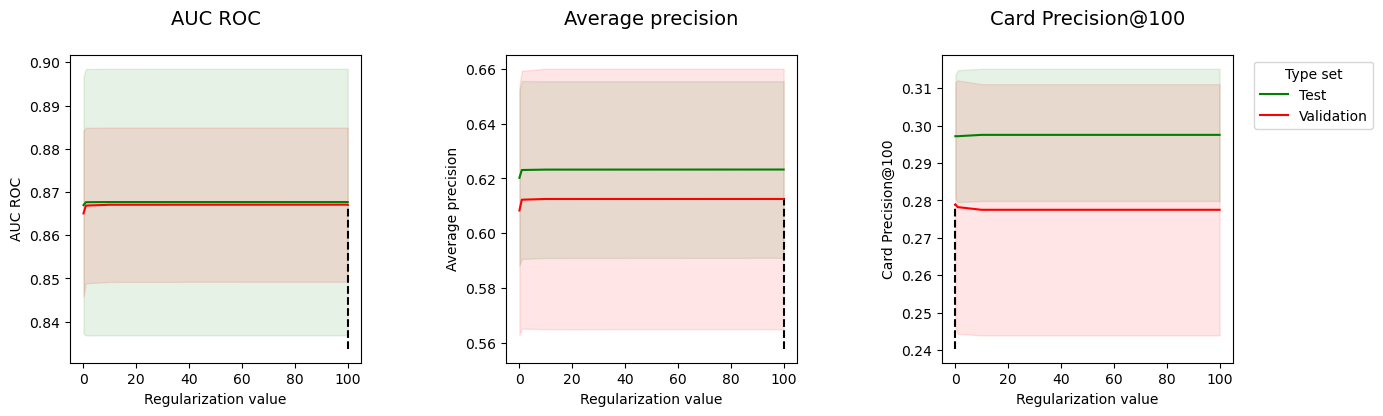

In [5]:
from logistic_regression import main as logistic_regression

performance, execution_time, summary = logistic_regression()

In [6]:
performance

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.866972,0.014858,0.620231,0.015977,0.297143,0.008207,"{'clf__C': 0.1, 'clf__random_state': 0}",1.132060,0.865052,0.009591,0.608330,0.022740,0.278929,0.016300,0.1
1,0.867643,0.015404,0.623081,0.016204,0.297143,0.008806,"{'clf__C': 1, 'clf__random_state': 0}",1.275606,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.0
2,0.867678,0.015415,0.623224,0.016087,0.297500,0.008828,"{'clf__C': 10, 'clf__random_state': 0}",1.258489,0.867050,0.008918,0.612526,0.023715,0.277500,0.016763,10.0
3,0.867680,0.015419,0.623253,0.016074,0.297500,0.008828,"{'clf__C': 100, 'clf__random_state': 0}",1.318316,0.867071,0.008912,0.612537,0.023712,0.277500,0.016763,100.0


In [7]:
print(f"Execution Time {execution_time[0]}")

Execution Time 15.359215021133423


In [8]:
summary

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100.0,100.0,0.1
Validation performance,0.867+/-0.01,0.613+/-0.02,0.279+/-0.02
Test performance,0.868+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameter(s),100.0,100.0,10.0
Optimal test performance,0.868+/-0.02,0.623+/-0.02,0.298+/-0.01


### Convolutional Neural Network

*Note: this next cell might take a while to complete, and you may need to buy compute units in Google Collab to successfully run it. This is the reason we are not so much extensive on searching for best parameters in this model.*

The following cell runs the Convolutional Neural Network Model Selection process. The dotted line in the plots represent the best hyperparameter found for the given metric. Later, there is a summary of the performance of the different model choices, the execution time taken to run the model selection process, and the summary of the optimal parameters found:

Load  files
919767 transactions loaded, containing 8195 fraudulent transactions
Selected device is cpu
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Convolutional Neural Network Done


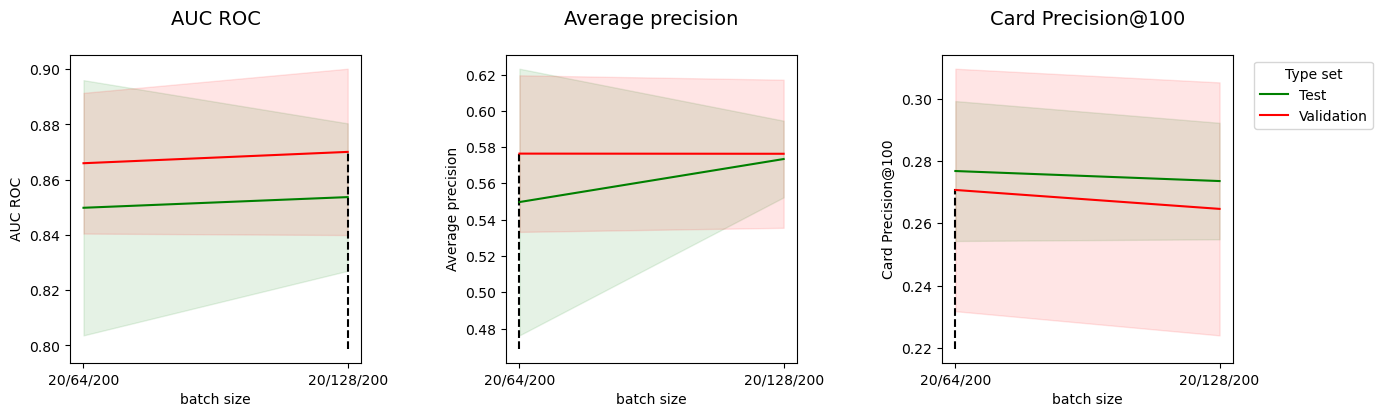

In [9]:
from convolutional_neural_network import main as convolutional_neural_network

performance, execution_time, summary = convolutional_neural_network()

In [10]:
performance

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.849835,0.023101,0.549697,0.036744,0.276786,0.01122,"{'clf__batch_size': 64, 'clf__lr': 0.001, 'clf...",619.162499,0.865966,0.012737,0.576395,0.021574,0.270714,0.019444,20/2/64/200/0.2
1,0.853702,0.013350,0.573409,0.010560,0.273571,0.00934,"{'clf__batch_size': 128, 'clf__lr': 0.001, 'cl...",571.252848,0.870070,0.015056,0.576310,0.020407,0.264643,0.020288,20/2/128/200/0.2


In [11]:
print(f"Execution Time {execution_time[0]}")

Execution Time 1271.627182006836


In [12]:
summary

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,20/2/128/200/0.2,20/2/64/200/0.2,20/2/64/200/0.2
Validation performance,0.87+/-0.02,0.576+/-0.02,0.271+/-0.02
Test performance,0.854+/-0.01,0.55+/-0.04,0.277+/-0.01
Optimal parameter(s),20/2/128/200/0.2,20/2/128/200/0.2,20/2/64/200/0.2
Optimal test performance,0.854+/-0.01,0.573+/-0.01,0.277+/-0.01


## Conclusion

Based on the hyperparameter options we made in model selection, Logistic Regression was much faster to train and had better performance than the Convolutional Neural Network.
As time permits more options could be added to the Convolutional Neural Network model selection process to possibly achieve further improvement.